# This is the Coursera capstone project (Seattle collisions)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
dfOriginal = pd.read_csv('Data-Collisions.csv')

C:\Users\carniato\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data cleaning

Inspect data first

In [4]:
def computeDetails(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
    details = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)
    details.columns = cols
    
    return details

def GetIndexses(df,col_missing_data,missingValue):
    if not missingValue :
        # nan
        indexses = df[col_missing_data].isnull()
    else:
        # comparables
        indexses = df[col_missing_data]==missingValue
        
    return indexses

def InputMissingData(df, col_missing_data, col_ref, missingValue = None):
    #group by nan or missing value
    invalid_idxs = GetIndexses(df, col_missing_data, missingValue)
    df_notval = df[invalid_idxs]
    df_notval = df_notval.groupby(col_ref).sum()  
    #print(df_notval[col_ref])
    #the valid entries
    df_val = df[~invalid_idxs]
    
    #now check the values of the reference column
    for r in df_notval.index.values:
        if isinstance(r, str):
            #a string (e.g. a location)
            df_loc = df_val[df_val[col_ref]==r]
        elif len(r)==2:
            #two doubles
            df_loc = df_val[(df_val[col_ref[0]]==r[0]) & (df_val[col_ref[1]]==r[1])]
        
        if len(df_loc) > 0:
            val = df_loc[col_missing_data].iloc[0]
            if isinstance(r, str):
                #substitute with the first valid value
                df.loc[(df[col_ref]==r) & invalid_idxs,col_missing_data]=val
            elif len(r) ==2:
                df.loc[(df[col_ref[0]]==r[0]) &(df[col_ref[1]]==r[1]) & invalid_idxs, col_missing_data] = val
        
    return df     

def bar_chart(datafr, feature):
    severityOne = datafr[datafr['SEVERITYCODE']==1][feature].value_counts()
    #print(severityOne[0]/(severityOne[0] + severityOne[1]))
    severityTwo = datafr[datafr['SEVERITYCODE']==2][feature].value_counts()
    #print(severityTwo[0]/(severityTwo[0] + severityTwo[1]))
    df = pd.DataFrame([severityOne,severityTwo])
    df.index = ['SEVERITYCODE 1','SEVERITYCODE 2']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(toLabel):
    le = LabelEncoder()
    le.fit(toLabel)
    toLabel_enc = le.transform(toLabel)
    return toLabel_enc

In [5]:
df = dfOriginal.copy()
details = computeDetails(df)
print(details)

                  types  counts  distincts   nulls  missing ration
SEVERITYCODE      int64  194673          2       0           0.000
X               float64  189339      23564    5334           2.740
Y               float64  189339      23840    5334           2.740
OBJECTID          int64  194673     194673       0           0.000
INCKEY            int64  194673     194673       0           0.000
COLDETKEY         int64  194673     194673       0           0.000
REPORTNO         object  194673     194670       0           0.000
STATUS           object  194673          2       0           0.000
ADDRTYPE         object  192747          4    1926           0.989
INTKEY          float64   65070       7615  129603          66.575
LOCATION         object  191996      24103    2677           1.375
EXCEPTRSNCODE    object   84811          3  109862          56.434
EXCEPTRSNDESC    object    5638          2  189035          97.104
SEVERITYCODE.1    int64  194673          2       0           0

Eliminate the columns that are semantically equal or similar to the target

In [6]:
df = df.drop(['SEVERITYCODE.1'], axis=1)
df = df.drop(['SEVERITYDESC'], axis=1)

Eliminate EXCEPTRSNDESC, not enough information

In [7]:
df['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    5638
Name: EXCEPTRSNDESC, dtype: int64

In [8]:
df = df.drop(['EXCEPTRSNDESC'], axis=1)

EXCEPTRSNCODE has no descriptive field 

In [9]:
df = df.drop(['EXCEPTRSNCODE'], axis=1)

Eliminate columns that cannot be used as prediction for an collisions

In [10]:
df = df.drop(['REPORTNO', 'COLLISIONTYPE','ST_COLCODE','ST_COLDESC','SDOT_COLCODE','SDOTCOLNUM','SDOT_COLDESC',
              'OBJECTID','INCKEY','COLDETKEY','STATUS','COLLISIONTYPE','INTKEY'],axis=1)

INATTENTIONIND id contain only yes, suppose the other equal to n

In [11]:
df['INATTENTIONIND'].value_counts()

Y    29805
Name: INATTENTIONIND, dtype: int64

In [12]:
df['INATTENTIONIND'] = df['INATTENTIONIND'].replace(np.nan,0)
df['INATTENTIONIND'] = df['INATTENTIONIND'].replace('Y',1)
df['INATTENTIONIND'].value_counts()

0    164868
1     29805
Name: INATTENTIONIND, dtype: int64

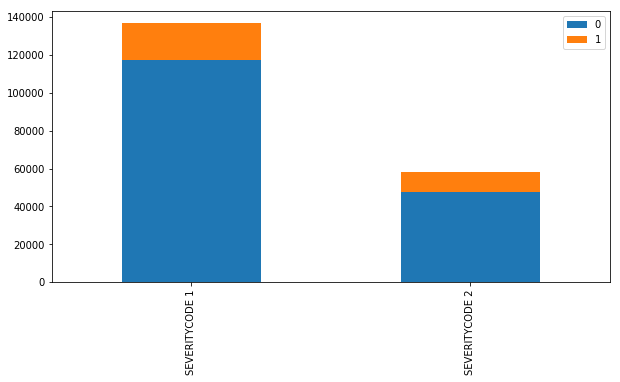

In [13]:
bar_chart(df, 'INATTENTIONIND')

In [14]:
df['PEDROWNOTGRNT'].value_counts()

Y    4667
Name: PEDROWNOTGRNT, dtype: int64

In [15]:
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].replace(np.nan,'N')
df['PEDROWNOTGRNT'].value_counts()

N    190006
Y      4667
Name: PEDROWNOTGRNT, dtype: int64

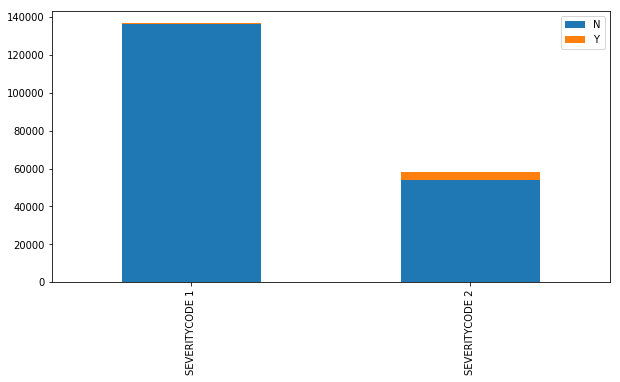

In [16]:
bar_chart(df, 'PEDROWNOTGRNT')

In [17]:
df['SPEEDING'] = df['SPEEDING'].replace(np.nan,'N')
df['SPEEDING'].value_counts()

N    185340
Y      9333
Name: SPEEDING, dtype: int64

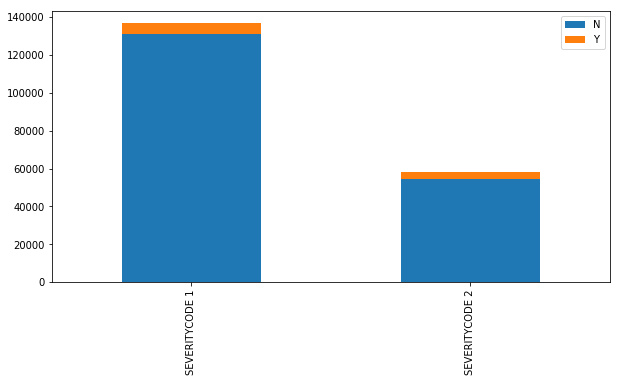

In [18]:
bar_chart(df, 'SPEEDING')

In [19]:
df['UNDERINFL'].value_counts()
df['UNDERINFL'] = df['UNDERINFL'].replace('N',0)
df['UNDERINFL'] = df['UNDERINFL'].replace('Y',1)  
df['UNDERINFL'] = df['UNDERINFL'].replace('0',0) 
df['UNDERINFL'] = df['UNDERINFL'].replace('1',1) 

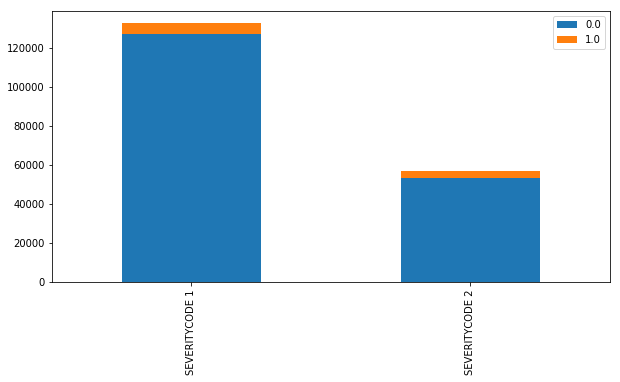

In [20]:
df['UNDERINFL'].value_counts()
bar_chart(df, 'UNDERINFL')

we could try to fill the missing 'JUNCTIONTYPE' by looking X,Y

In [22]:
original_length = len(df)
df = InputMissingData(df, 'JUNCTIONTYPE', ['X','Y'])
df_dropped = df.dropna()
print("percentage dropped ", (original_length-len(df_dropped))/len(df))

percentage dropped  0.05531840573679966


# Treat the dates

In [23]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

In [24]:
df = df.drop(['INCDATE'], axis=1)

check incidents by hour

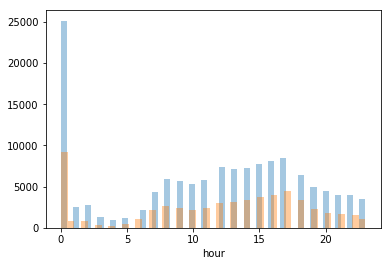

In [25]:
df['hour'] = df['INCDTTM'].dt.hour
df_selected = df[df['SEVERITYCODE']==1]
sns.distplot(df_selected['hour'],kde = False)
df_selected = df[df['SEVERITYCODE']==2]
sns.distplot(df_selected['hour'],kde = False)

Check day of the week

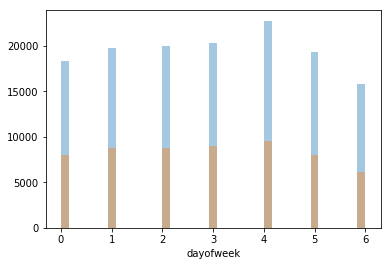

In [26]:
df['dayofweek'] = df['INCDTTM'].dt.dayofweek
df_selected = df[df['SEVERITYCODE']==1]
sns.distplot(df_selected['dayofweek'],kde = False)
df_selected = df[df['SEVERITYCODE']==2]
sns.distplot(df_selected['dayofweek'],kde = False)

Check month

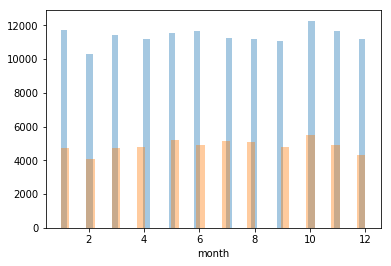

In [27]:
df['month'] = df['INCDTTM'].dt.month
df_selected = df[df['SEVERITYCODE']==1]
sns.distplot(df_selected['month'],kde = False)
df_selected = df[df['SEVERITYCODE']==2]
sns.distplot(df_selected['month'],kde = False)

In [28]:
df = df.drop(['INCDTTM'], axis=1)

# Check outliers

In [30]:
details = computeDetails(df)
print(details)

                  types  counts  distincts  nulls  missing ration
SEVERITYCODE      int64  194673          2      0           0.000
X               float64  189339      23564   5334           2.740
Y               float64  189339      23840   5334           2.740
ADDRTYPE         object  192747          4   1926           0.989
LOCATION         object  191996      24103   2677           1.375
PERSONCOUNT       int64  194673         47      0           0.000
PEDCOUNT          int64  194673          7      0           0.000
PEDCYLCOUNT       int64  194673          3      0           0.000
VEHCOUNT          int64  194673         13      0           0.000
JUNCTIONTYPE     object  192266          8   2407           1.236
INATTENTIONIND    int64  194673          2      0           0.000
UNDERINFL       float64  189789          3   4884           2.509
WEATHER          object  189592         12   5081           2.610
ROADCOND         object  189661         10   5012           2.575
LIGHTCOND 

PERSONCOUNT   0   81
2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64
PEDCOUNT   0   6
0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64
PEDCYLCOUNT   0   2
0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64
VEHCOUNT   0   12
2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7        

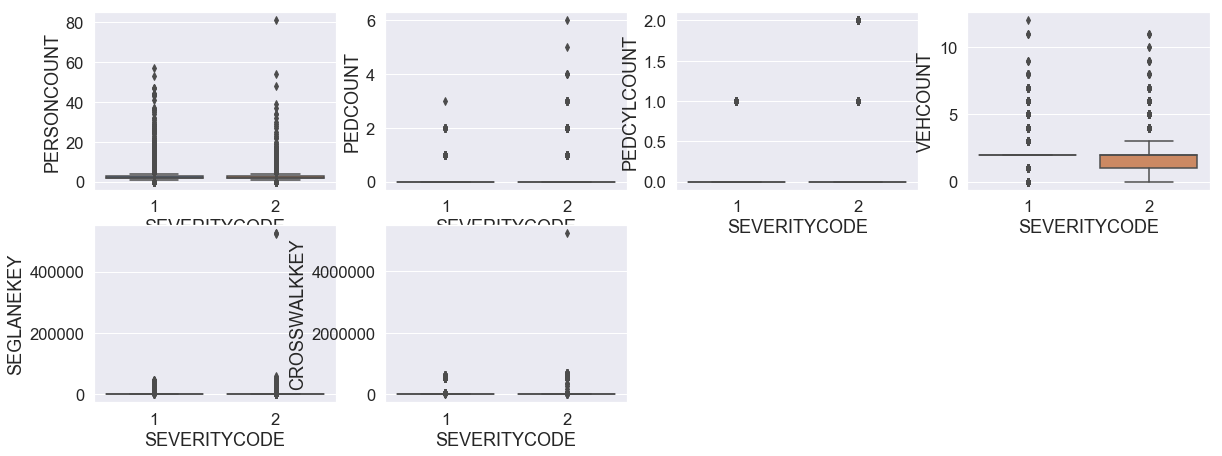

In [31]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
key='PERSONCOUNT'
fig1 = fig.add_subplot(441); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())

key='PEDCOUNT'
fig1 = fig.add_subplot(442); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())


key='PEDCYLCOUNT'
fig1 = fig.add_subplot(443); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())

key='VEHCOUNT'
fig1 = fig.add_subplot(444); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())

key='SEGLANEKEY'
fig1 = fig.add_subplot(445); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())

key='CROSSWALKKEY'
fig1 = fig.add_subplot(446); sns.boxplot(x='SEVERITYCODE', y=key, data=df[['SEVERITYCODE', key]])
print(key,' ', df[key].min(),' ',df[key].max())
print(df[key].value_counts())

remove outliers

In [32]:
len_before = len(df)
df = df[df['PERSONCOUNT']<81]
df = df[df['SEGLANEKEY']<525241]
df = df[df['CROSSWALKKEY']<5239700]
len_after = len(df)
print("Num outliers removed ",len_before-len_after)

Num outliers removed  3


check distributions

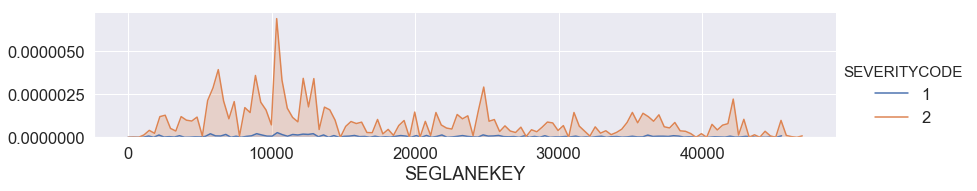

Num outliers removed  4


In [35]:
key='SEGLANEKEY'
len_before = len(df)
df_selected = df[df[key]<50000]
facet = sns.FacetGrid(df_selected, hue="SEVERITYCODE",aspect=4)
facet.map(sns.kdeplot,key,shade= True)
facet.add_legend()
plt.show()
len_after = len(df_selected)
print("Num outliers removed ",len_before-len_after)

#df = df[df[key]<50000]

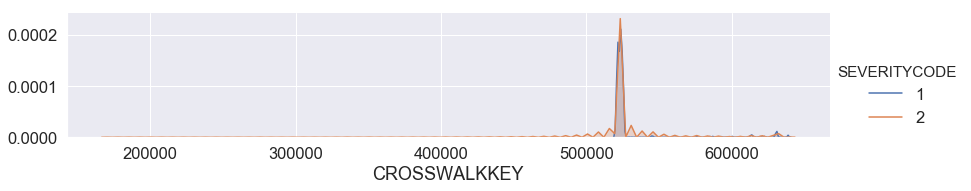

Num outliers removed  191130


In [42]:
key='CROSSWALKKEY'
len_before = len(df)
df_selected = df[(df[key]>100000) & (df[key]<650000)]
facet = sns.FacetGrid(df_selected, hue="SEVERITYCODE",aspect=4)
facet.map(sns.kdeplot,key,shade= True)
facet.add_legend()
plt.show()
len_after = len(df_selected)
print("Num outliers removed ",len_before-len_after)

# Save cleaned up dataframe

In [43]:
df.dropna(inplace=True)
df.to_csv('Data-Collisions-cleaned.csv')

# Load cleaned dataframe

In [181]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [182]:
df = pd.read_csv('Data-Collisions-cleaned.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.dropna(inplace=True)
details = computeDetails(df)
print(details)

                  types  counts  distincts  nulls  missing ration
SEVERITYCODE      int64  183901          2      0           0.000
X               float64  183901      23150      0           0.000
Y               float64  183901      23414      0           0.000
ADDRTYPE         object  183901          2      0           0.000
LOCATION         object  183901      23465      0           0.000
PERSONCOUNT       int64  183901         46      0           0.000
PEDCOUNT          int64  183901          7      0           0.000
PEDCYLCOUNT       int64  183901          3      0           0.000
VEHCOUNT          int64  183901         13      0           0.000
JUNCTIONTYPE     object  183901          7      0           0.000
INATTENTIONIND    int64  183901          2      0           0.000
UNDERINFL       float64  183901          2      0           0.000
WEATHER          object  183901         11      0           0.000
ROADCOND         object  183901          9      0           0.000
LIGHTCOND 

In [183]:
df.describe()

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SEGLANEKEY,CROSSWALKKEY,hour,dayofweek,month
count,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000,183901.000
mean,1.305,-122.330,47.620,2.468,0.039,0.030,1.974,0.158,0.048,276.567,10133.984,11.465,2.943,6.563
std,0.460,0.030,0.056,1.347,0.203,0.171,0.556,0.365,0.214,3157.664,72624.106,6.927,1.923,3.423
min,1.000,-122.419,47.496,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,1.000,-122.349,47.576,2.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,7.000,1.000,4.000
50%,1.000,-122.330,47.615,2.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,13.000,3.000,7.000
75%,2.000,-122.312,47.664,3.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,17.000,5.000,10.000
max,2.000,-122.239,47.734,57.000,6.000,2.000,12.000,1.000,1.000,525169.000,703480.000,23.000,6.000,12.000


In [184]:
#https://machinelearningmastery.com/feature-selection-with-categorical-data/
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(toLabel):
    le = LabelEncoder()
    le.fit(toLabel)
    toLabel_enc = le.transform(toLabel)
    return toLabel_enc

df['ADDRTYPE'] = prepare_categorical(df['ADDRTYPE'])
df['LOCATION'] = prepare_categorical(df['LOCATION'])
df['JUNCTIONTYPE'] = prepare_categorical(df['JUNCTIONTYPE'])
df['UNDERINFL'] = prepare_categorical(df['UNDERINFL'])
df['WEATHER'] = prepare_categorical(df['WEATHER'])
df['ROADCOND'] = prepare_categorical(df['ROADCOND'])
df['LIGHTCOND'] = prepare_categorical(df['LIGHTCOND'])
df['PEDROWNOTGRNT'] = prepare_categorical(df['PEDROWNOTGRNT'])
df['SPEEDING'] = prepare_categorical(df['SPEEDING'])
df['HITPARKEDCAR'] = prepare_categorical(df['HITPARKEDCAR'])

details = computeDetails(df)
print(details)
#df = df.iloc[:30000,:]

                  types  counts  distincts  nulls  missing ration
SEVERITYCODE      int64  183901          2      0           0.000
X               float64  183901      23150      0           0.000
Y               float64  183901      23414      0           0.000
ADDRTYPE          int32  183901          2      0           0.000
LOCATION          int32  183901      23465      0           0.000
PERSONCOUNT       int64  183901         46      0           0.000
PEDCOUNT          int64  183901          7      0           0.000
PEDCYLCOUNT       int64  183901          3      0           0.000
VEHCOUNT          int64  183901         13      0           0.000
JUNCTIONTYPE      int32  183901          7      0           0.000
INATTENTIONIND    int64  183901          2      0           0.000
UNDERINFL         int64  183901          2      0           0.000
WEATHER           int32  183901         11      0           0.000
ROADCOND          int32  183901          9      0           0.000
LIGHTCOND 

In [185]:
#df = pd.get_dummies(df, columns=['PERSONCOUNT','PEDCOUNT','VEHCOUNT','JUNCTIONTYPE','INATTENTIONIND','UNDERINFL','WEATHER',
#                                'ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','hour','dayofweek','month'])
#details = computeDetails(df)
#print(details)

# Benchmark a first tree model

In [186]:
y = df['SEVERITYCODE']
X = df.drop(['SEVERITYCODE'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [187]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

In [188]:
clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
clf.fit(X_train_scaled, y_train) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6706720037843095

try imblearn

In [189]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X_train_scaled, y_train)
print('X_train len ', len(X_train),' len X_rus', len(X_rus))

X_train len  123213  len X_rus 171234


In [190]:
clf = DecisionTreeClassifier(criterion="entropy",random_state=42)
clf.fit(X_rus, y_rus) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6677631396507734

# Feature selection

In [191]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
#def select_features(X_train, y_train, X_test):
#    fs = SelectKBest(score_func=chi2, k='all')
#    fs.fit(X_train, y_train)
#    X_train_fs = fs.transform(X_train)
#    X_test_fs = fs.transform(X_test)
#    return X_train_fs, X_test_fs, fs

In [192]:
#X_train_selected = X_train.drop(['X', 'Y'],axis=1)
#X_test_selected = X_test.drop(['X', 'Y'],axis=1)
#X_train_fs, X_test_fs, fs = select_features(X_train_selected, y_train, X_test_selected)
#column_val =X_train_selected.columns.values
#columns_to_drop=[]
#for i in range(len(fs.scores_)):
#    #print('Feature %s: %f' % (column_val[i], fs.scores_[i]))
#    if fs.scores_[i]<100:
#        columns_to_drop.append(column_val[i])

In [193]:
#columns_to_drop=['month','dayofweek','SPEEDING']
#X_train_selected = X_train.drop(columns_to_drop,axis=1)
#X_test_selected = X_test.drop(columns_to_drop,axis=1)

#train_scaler = StandardScaler()
#X_train_scaled = train_scaler.fit_transform(X_train_selected)
#X_test_scaled = train_scaler.transform(X_test_selected)

In [194]:
#clf = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',random_state=42)
#clf.fit(X_train_scaled, y_train) 
#yhat = clf.predict(X_test_scaled)
#f1_score(y_test, yhat, average='weighted') 

# XGBOOST

In [195]:
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

0.6677631396507734

In [196]:
from sklearn.utils import class_weight
def ComputeWeights(y_val):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(y_val), y_val)
    weights = []
    y_train = np.array(y_val)
    for i in range(len(y_val)):
        if y_val[i] == 1:
            weights.append(sample_weights[0])
        elif y_val[i] == 2:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

In [197]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

import xgboost as xgb
clf = xgb.XGBClassifier(n_jobs=3)

weights = ComputeWeights(y_train)
clf.fit(X_train_scaled, y_train,sample_weight=weights) 
yhat = clf.predict(X_test_scaled)
f1_score(y_test, yhat, average='weighted') 

d:\apps\python_3_7_4\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[1 2], y=[1 1 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


0.6970209176205341

In [198]:
current_accuracy =  metrics.accuracy_score(y_test, yhat)
print(current_accuracy)

0.6859840495649882
